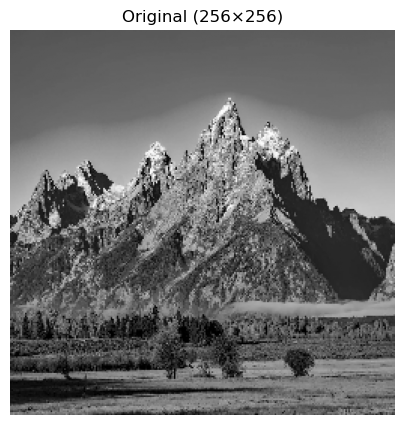

In [1]:
# %%
# Q12 — Homomorphic Filtering (illumination correction) in frequency domain
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- load grayscale image (resize for consistency) ---
img_path = "../image2.jpg"   
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(img_path)
img = cv2.resize(img, (256, 256)).astype(np.float32)

plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title("Original (256×256)")
plt.axis("off"); plt.show()


In [2]:
# %%
def fft2c(im):
    F  = np.fft.fft2(im)
    Fc = np.fft.fftshift(F)
    return Fc

def ifft2c(Fc):
    F  = np.fft.ifftshift(Fc)
    im = np.fft.ifft2(F).real
    return im

def meshgrid_radius(shape):
    rows, cols = shape
    u = np.arange(rows) - rows//2
    v = np.arange(cols) - cols//2
    V, U = np.meshgrid(v, u)  # (row, col)
    R = np.sqrt(U**2 + V**2)
    return R


In [3]:
# %%
def homomorphic_mask(shape, D0=30, gamma_l=0.7, gamma_h=1.5):
    """Gaussian-based homomorphic filter mask."""
    R = meshgrid_radius(shape)
    sigma = max(1e-6, D0/np.sqrt(2))
    Hhp = 1.0 - np.exp(-(R**2) / (2*sigma**2))  # Gaussian high-pass in [0,1]
    H = (gamma_h - gamma_l) * Hhp + gamma_l
    return H.astype(np.float32)


In [4]:
# %%
def homomorphic_filter(im_u8, D0=30, gamma_l=0.7, gamma_h=1.5, eps=1e-6):
    """
    im_u8: grayscale uint8/float image in [0,255]
    Steps: log -> FFT -> multiply by H -> IFFT -> exp -> normalize
    """
    im = im_u8.astype(np.float32)
    # scale to [0,1] for log domain, avoid log(0)
    im01 = np.clip(im/255.0, 0.0, 1.0)
    log_im = np.log(im01 + eps)

    # frequency domain processing
    Fc = fft2c(log_im)
    H  = homomorphic_mask(log_im.shape, D0=D0, gamma_l=gamma_l, gamma_h=gamma_h)
    Gc = Fc * H
    g  = ifft2c(Gc)  # back to log domain (filtered)

    # exponentiate, renormalize to [0,255]
    out01 = np.exp(g)
    out01 = np.clip(out01, 0.0, 1.0)
    out = (out01 * 255.0).astype(np.uint8)

    return out, H, log_im


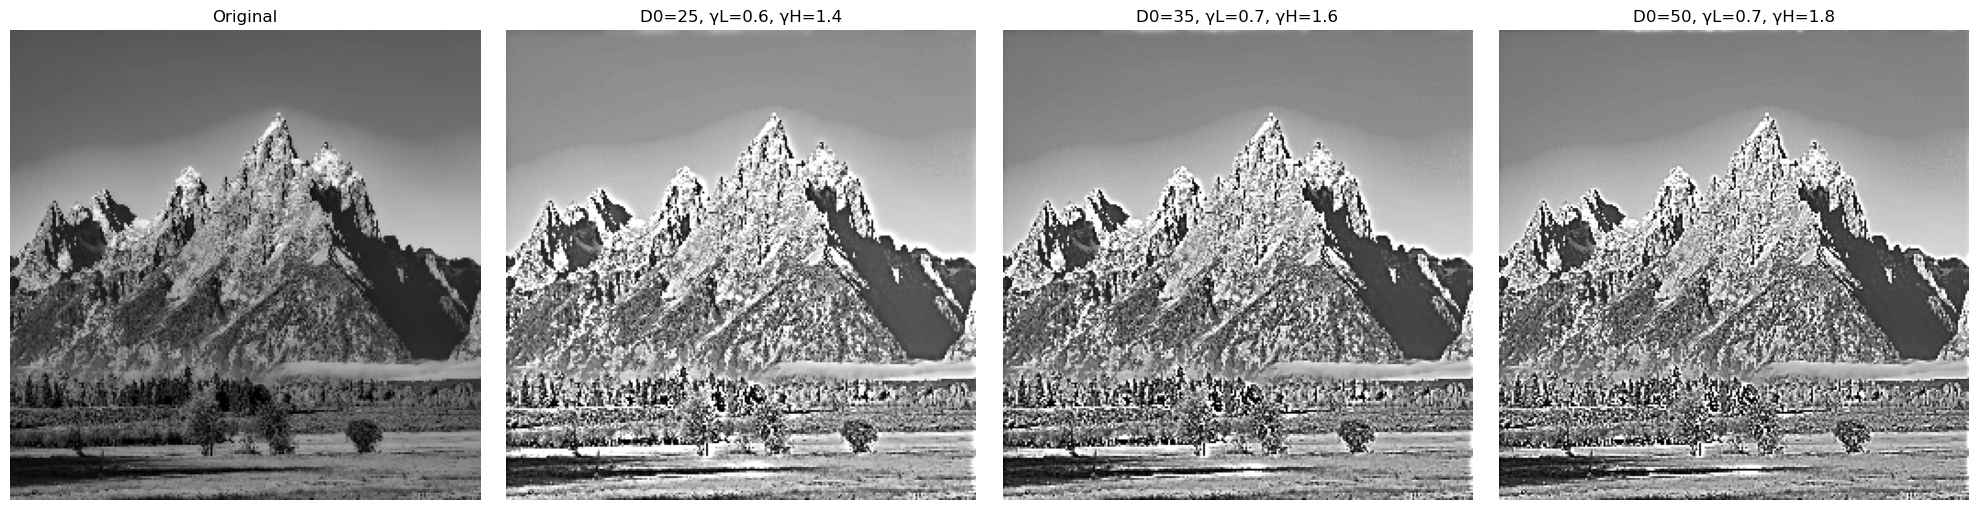

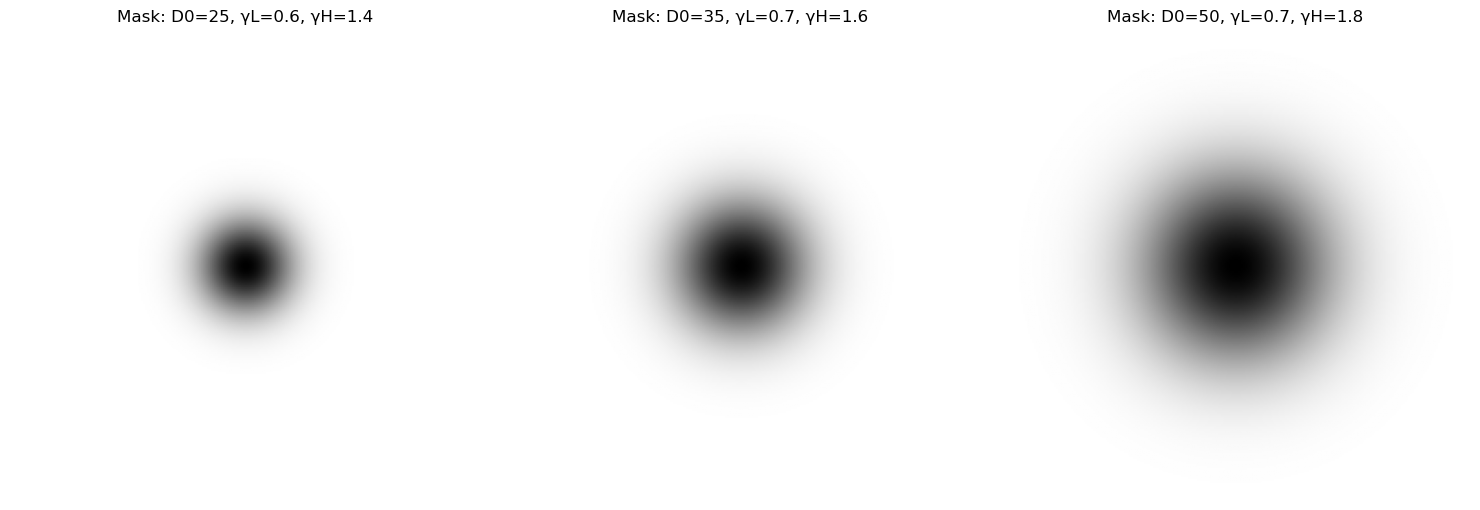

In [5]:
# %%
params = [
    (25, 0.6, 1.4),
    (35, 0.7, 1.6),
    (50, 0.7, 1.8),
]

outs = []
Hs   = []
for D0, gl, gh in params:
    out, H, _ = homomorphic_filter(img, D0=D0, gamma_l=gl, gamma_h=gh)
    outs.append((f"D0={D0}, γL={gl}, γH={gh}", out))
    Hs.append((f"Mask: D0={D0}, γL={gl}, γH={gh}", H))

# show outputs
cols = len(outs) + 1
plt.figure(figsize=(5*cols,5))
plt.subplot(1, cols, 1)
plt.imshow(img, cmap="gray"); plt.title("Original"); plt.axis("off")
for i, (t, im_o) in enumerate(outs, start=2):
    plt.subplot(1, cols, i)
    plt.imshow(im_o, cmap="gray"); plt.title(t); plt.axis("off")
plt.tight_layout(); plt.show()

# show masks
plt.figure(figsize=(5*len(Hs),5))
for i, (t, H) in enumerate(Hs, start=1):
    plt.subplot(1, len(Hs), i)
    plt.imshow(H, cmap="gray")
    plt.title(t); plt.axis("off")
plt.tight_layout(); plt.show()


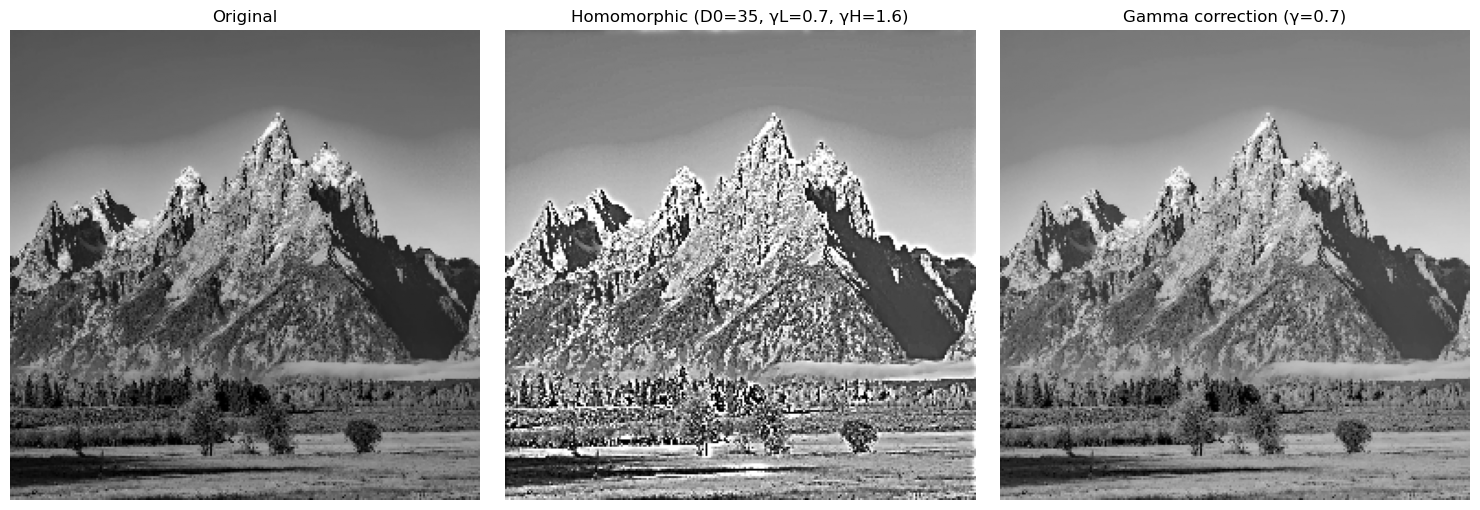

In [6]:
# %%
def gamma_correct(im_u8, gamma=0.7):
    im01 = (im_u8.astype(np.float32))/255.0
    out  = np.power(im01, gamma)
    return np.clip(out*255.0, 0, 255).astype(np.uint8)

homo_out, _, _ = homomorphic_filter(img, D0=35, gamma_l=0.7, gamma_h=1.6)
gamma_out = gamma_correct(img, gamma=0.7)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(img, cmap="gray");       ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(homo_out, cmap="gray");  ax[1].set_title("Homomorphic (D0=35, γL=0.7, γH=1.6)"); ax[1].axis("off")
ax[2].imshow(gamma_out, cmap="gray"); ax[2].set_title("Gamma correction (γ=0.7)"); ax[2].axis("off")
plt.tight_layout(); plt.show()


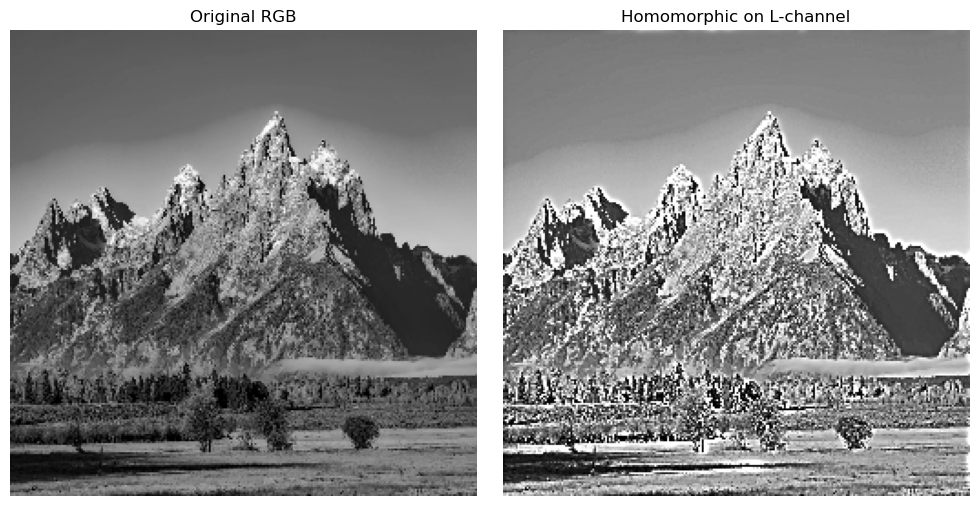

In [7]:
# %%
def homomorphic_color_rgb(img_rgb_u8, D0=35, gamma_l=0.7, gamma_h=1.6):
    # to RGB if not already
    if img_rgb_u8.ndim == 2:
        img_rgb_u8 = cv2.cvtColor(img_rgb_u8, cv2.COLOR_GRAY2RGB)
    lab = cv2.cvtColor(img_rgb_u8, cv2.COLOR_RGB2LAB).astype(np.float32)
    L, a, b = lab[:,:,0], lab[:,:,1], lab[:,:,2]

    # L channel is in [0,255]; run homomorphic just on L
    L_out, _, _ = homomorphic_filter(L, D0=D0, gamma_l=gamma_l, gamma_h=gamma_h)
    lab_out = np.stack([L_out.astype(np.uint8), a.astype(np.uint8), b.astype(np.uint8)], axis=2)
    rgb_out = cv2.cvtColor(lab_out, cv2.COLOR_LAB2RGB)
    return rgb_out

# demo (convert our grayscale to RGB for demonstration)
img_rgb = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2RGB)
rgb_homo = homomorphic_color_rgb(img_rgb, D0=35, gamma_l=0.7, gamma_h=1.6)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_rgb);  plt.title("Original RGB"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(rgb_homo); plt.title("Homomorphic on L-channel"); plt.axis("off")
plt.tight_layout(); plt.show()

